In [9]:
# Import all libaries
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as npy

In [10]:
# Import all libaries
import numpy
import json
import pandas as pan
import os as OS

In [12]:
# Map directories
map_base_dir = 'input_dataset/'
map_img_dir = 'input_dataset/train/images/'

In [15]:
filename = 'annotation_on_data.json'
json_path = OS.path.join(map_base_dir, filename)
with open(json_path,'r') as f:
    annot_data = json.load(f)

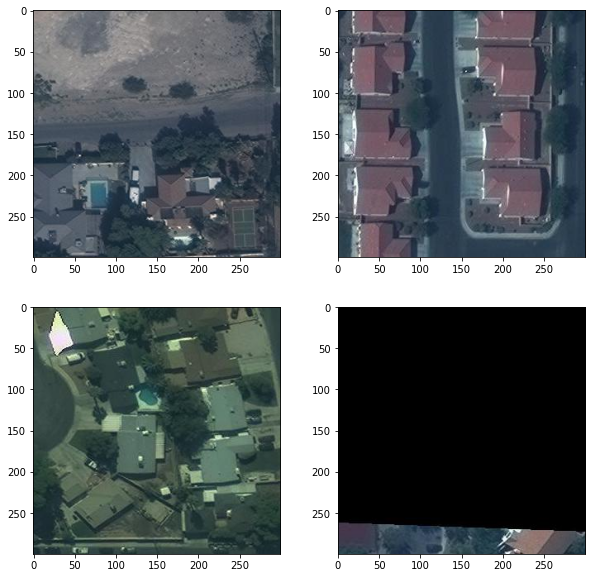

In [16]:
image_df = pan.DataFrame(annot_data['images'])
image_df.sample(6)
fig, m_axs = plt.subplots(2,2,figsize=(10,10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(OS.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [18]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(6)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
254159,2365844,277278,"[[225.0, 300.0, 223.0, 265.0, 249.0, 262.0, 25...",2338.0,"[223.0, 223.0, 77.0, 77.0]",100,0
2165754,1551990,182060,"[[232.0, 266.0, 233.0, 281.0, 224.0, 281.0, 22...",128.0,"[224.0, 224.0, 57.0, 9.0]",100,0
592141,547451,64176,"[[21.0, 92.99999999999999, 105.0, 93.0, 105.0,...",2184.0,"[21.0, 21.0, 84.0, 84.0]",100,0
902126,1371983,160962,"[[300.0, 214.99999999999997, 300.0, 205.999999...",0.0,"[205.99999999999997, 300.0, 94.00000000000003,...",100,0
1169789,1610029,188843,"[[55, 102, 25, 103, 25, 57, 76, 56, 77, 81, 55...",1908.0,"[25, 25, 78, 52]",100,0
2296832,589508,69193,"[[40.0, 287.0, 35.0, 287.0, 35.0, 300.0, 0.0, ...",1582.0,"[0.0, 0.0, 300.0, 40.0]",100,0


In [20]:
full_df = pan.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(6)

280741 + 2395553 -> 2395553


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
296622,1962088,230153,"[[93.0, 175.0, 93.0, 185.0, 83.0, 185.0, 83.0,...",100.0,"[83.0, 83.0, 102.0, 10.0]",100,0,230153,000000230153.jpg,300,300
1283145,100501,11875,"[[193, 14, 129, 14, 129, 0, 193, 0, 193, 14]]",896.0,"[14, 129, 179, 64]",100,0,11875,000000011875.jpg,300,300
925153,85995,10168,"[[136.0, 45.0, 125.0, 45.0, 125.0, 76.0, 92.0,...",2349.0,"[45.0, 88.0, 91.0, 48.0]",100,0,10168,000000010168.jpg,300,300
453841,1183049,138862,"[[20.0, 231.0, 19.0, 209.0, 55.0, 208.0, 56.0,...",793.0,"[19.0, 19.0, 212.0, 37.0]",100,0,138862,000000138862.jpg,300,300
935799,972551,114192,"[[300, 249, 297, 249, 297, 196, 300, 196, 300,...",159.0,"[249, 297, 51, 3]",100,0,114192,000000114192.jpg,300,300
1630795,2266103,265593,"[[59, 213, 110, 242, 95, 258, 85, 253, 78, 262...",3754.0,"[59, 19, 214, 91]",100,0,265593,000000265593.jpg,300,300


In [21]:
# Create the annotations on the buidlings from the json file
def create_boxes(in_rows):
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox -> coco std.
        (start_y, start_x, wid_y,wid_x) = in_row['bbox']
        box_list += [Rectangle((start_x,start_y), wid_y, wid_x)]
    return box_list

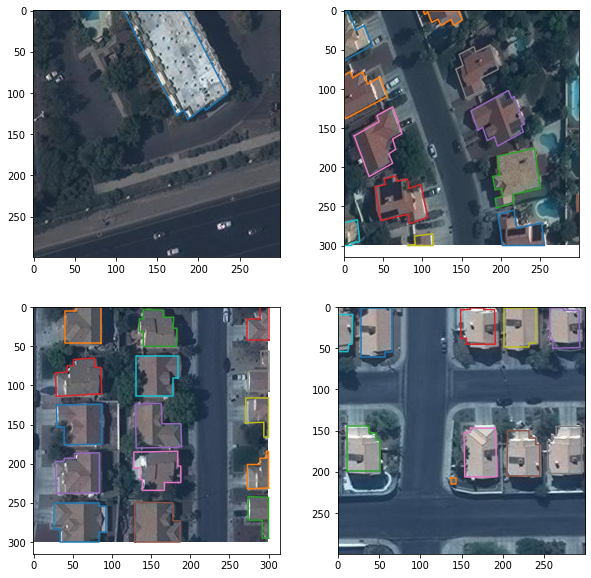

In [22]:
fig, m_axs = plt.subplots(2, 2, figsize = (10,10))
for c_ax, (c_id, c_df) in zip (m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [23]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

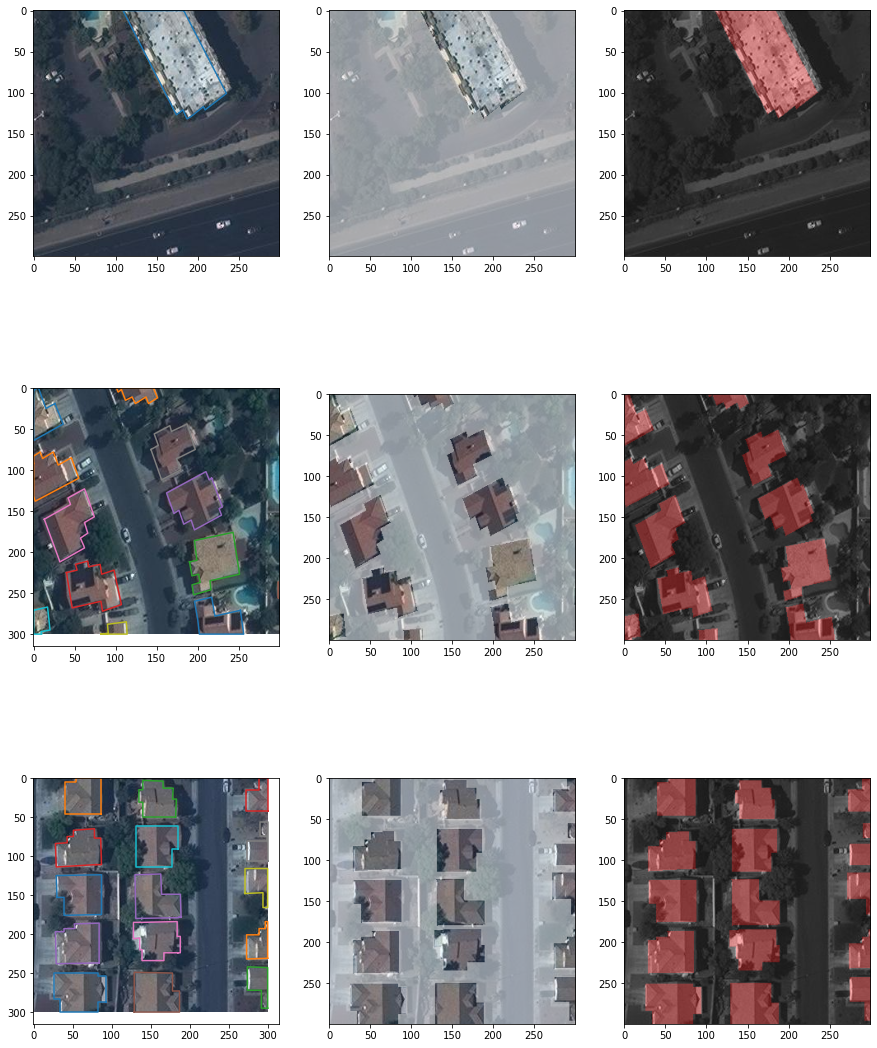

In [24]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [26]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1795262 training boxes
600291 validation boxes
